In [1]:
import os
import time
import csv
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class VAE(nn.Module):
    def __init__(self, input_shape, z_dim):
        super(VAE, self).__init__()

        self.image_size = 3 * 64 * 64
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.fc1 = nn.Linear(256 * 2 * 2, z_dim)
        self.fc2 = nn.Linear(256 * 2 * 2, z_dim)
        self.fc3 = nn.Linear(z_dim, 256 * 2 * 2)

        self.deconv1 = nn.ConvTranspose2d(256 * 2 * 2, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)


    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = h.view(-1, 256 * 2 * 2)
        return self.fc1(h), self.fc2(h)


    def reparameterize(self, mu, logvar):
        """Generate latent vector from mean and stddev"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu


    def decode(self, z):
        h = self.fc3(z).view(-1, 256 * 2 * 2, 1, 1)
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))
        h = F.sigmoid(self.deconv4(h))
        return h


    def forward(self, x, encode=False, mean=False):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if encode:
            if mean:
                return mu
            return z
        return self.decode(z), mu, logvar

In [4]:
class VAEDataset(Dataset):

    def __init__(self, size=20):
        """ Instanciate a dataset extending PyTorch """
        self.frames = []
        for i in os.listdir('/floyd/input/car_racing_data/'):
            obs = np.load(os.path.join('/floyd/input/car_racing_data', i))['obs']
            for ob in obs:
                self.frames.append(ToTensor()(Image.fromarray(ob).resize((64,64))))
#         for i in os.listdir('/floyd/input/driving_data/'):
#             obs = ToTensor()(np.array(Image.open(os.path.join('/floyd/input/driving_data/', i)).resize((64,64))))
#             self.frames.append(obs)

    def __len__(self):
        return len(self.frames)


    def __getitem__(self, idx):
        return self.frames[idx]

In [5]:
def loss_fn(recon_x, x, mu, logvar):
    batch_size = x.size()[0]
    loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     loss /= batch_size
#     kld /= batch_size
    return loss + kld

record_loss = []
def train_vae():
    """Train a VAE to create a latent representation environment"""
    epochs = 5
    vae = VAE((320, 160, 3), 50).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-4)
    
    dataset = VAEDataset()
    training_set = DataLoader(dataset, batch_size=128, num_workers=4, shuffle=True)
    for e in range(epochs):
        print("Epoch: {}/{}".format(e+1, epochs))
        for i, frames in enumerate(training_set):
            optimizer.zero_grad()
            #print frames
            frames = frames.to(device)
            recon_x, mu, logvar = vae(frames)
            loss = loss_fn(recon_x, frames, mu, logvar)

            loss.backward()
            optimizer.step()
            
            record_loss.append(loss)

            if i % 20 == 0:
                print("Loss: {}".format(float(loss.data)))
        
    torch.save(vae.state_dict(), 'model.pt')

In [6]:
train_vae()

KeyboardInterrupt: 

In [6]:
vae = VAE((320, 160, 3), 50)
vae.load_state_dict(torch.load('model.pt', map_location='cpu'))

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


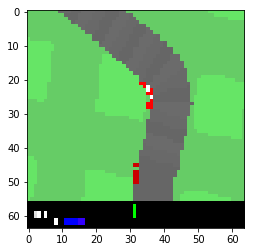

In [7]:
# Test VAE
img = np.load('/floyd/input/car_racing_data/trial_1995_0.npz')['obs'][120]
img = Image.fromarray(img).resize((64,64))
plt.imshow(img)
im = vae(ToTensor()(img).unsqueeze_(0),encode=False)[0]

In [ ]:
img = im.permute((0,2,3,1))
im_to_show = img.detach().numpy()[0]
plt.imshow(im_to_show)

## VRNN

In [3]:
HIDDEN_UNTIS = 256
z_dim = 50

class VRNN(nn.Module):
    def __init__(self):
        super(VRNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        self.fc1 = nn.Linear(256 * 2 * 2, z_dim)

        self.encoder = nn.Linear(50+256,50*2) # output hyperparameters
        self.phi_z = nn.Sequential(nn.Linear(50,50), nn.ReLU())
        
        self.fc3 = nn.Linear(z_dim+256, 256 * 2 * 2)
        self.deconv1 = nn.ConvTranspose2d(256 * 2 * 2, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)

        self.prior = nn.Linear(256,50*2) # output hyperparameters
        self.rnn = nn.GRUCell(50*2,256)
        
    def forward(self, x, hidden):
        # Feature extraction
        #x = x.unsqueeze_(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        
        z_prior = self.prior(hidden)
        z_infer = self.encoder(torch.cat([x,hidden], dim=1))
        z = Variable(torch.randn(x.size(0),50)).to(device)*z_infer[:,50:].exp()+z_infer[:,:50]
        z = self.phi_z(z)
        
        # Decode
        x_out = self.fc3(torch.cat([x,hidden], dim=1)).view(-1, 256 * 2 * 2, 1, 1)
        x_out = F.relu(self.deconv1(x_out))
        x_out = F.relu(self.deconv2(x_out))
        x_out = F.relu(self.deconv3(x_out))
        x_out = F.sigmoid(self.deconv4(x_out))
        
        hidden_next = self.rnn(torch.cat([x,z], dim=1),hidden)
        return x_out, hidden_next, z_prior, z_infer
    
    def calculate_loss(self, x, hidden):
        x_out, hidden_next, z_prior, z_infer = self.forward(x, hidden)
        loss1 = nn.functional.binary_cross_entropy(x_out, x, reduction='sum')
        
        mu_infer, log_sigma_infer = z_infer[:,:50], z_infer[:,50:]
        mu_prior, log_sigma_prior = z_prior[:,:50], z_prior[:,50:]
        loss2 = (2*(log_sigma_infer-log_sigma_prior)).exp() \
                + ((mu_infer-mu_prior)/log_sigma_prior.exp())**2 \
                - 2*(log_sigma_infer-log_sigma_prior) - 1
        loss2 = 0.5*loss2.sum(dim=1).mean()
        return loss1, loss2, hidden_next
    
    def generate(self, hidden=None, temperature=None):
        if hidden is None:
            hidden = Variable(torch.zeros(1,256)).to(device)
        if temperature is None:
            temperature = 0.8
        z_prior = self.prior(hidden)
        z = Variable(torch.randn(z_prior.size(0),50)).to(device)*z_prior[:,50:].exp()+z_prior[:,:50]
        z = self.phi_z(z)
        
        x_out = self.fc3(torch.cat([hidden, z], dim=1)).view(-1, 256*2*2,1,1)
        x_out = F.relu(self.deconv1(x_out))
        x_out = F.relu(self.deconv2(x_out))
        x_out = F.relu(self.deconv3(x_out))
        x_out = F.sigmoid(self.deconv4(x_out))
        x_sample = x = x_out.div(temperature)
        x_sample = x_sample.exp().squeeze_(0)
        gen_image = []
        for chan in x_sample:
            gen_image.append(chan.multinomial(64).tolist())
        gen_image_ar = torch.Tensor(gen_image) / 255.0
        print(gen_image_ar.shape)
        x = gen_image_ar
        x = x.unsqueeze_(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        hidden_next = self.rnn(torch.cat([x,z], dim=1), hidden)
        return gen_image_ar[0], hidden_next
    
    def generate_images(self, n=10, temperature=None, hidden=None):
        for _ in range(n):
            x_sample, hidden = self.generate(hidden, temperature)
            print(x_sample.shape)
            x_sample = x_sample.permute((1,2,0))
            plt.imshow(x_sample)
            plt.show()

In [4]:
def train_vrnn():
    vrnn = VRNN().to(device)
    hidden = Variable(torch.zeros(200,256)).to(device)
    optimizer = torch.optim.Adam(vrnn.parameters(), lr=1e-3, weight_decay=1e-4)

    dataset = LSTMDataset()
    dataloader = DataLoader(dataset, batch_size=1, num_workers=1, collate_fn=collate_fn)
    epochs = 2
    
    for e in range(epochs):
        print("Epoch: {}/{}".format(e+1, epochs))
        for batch_idx, (frames, actions) in enumerate(dataloader):
            frames = frames.squeeze_(0).to(device)
            #actions = actions.squeeze_(0).to(device)
            x = frames

            optimizer.zero_grad()
            loss1, loss2, hidden = vrnn.calculate_loss(x, hidden)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            hidden.detach_()
            if batch_idx % 20 == 0:
                print('loss: {}'.format(loss))
                print('bce loss: {}'.format(loss1))
                print('kl loss: {}'.format(loss2))
    
    torch.save(vrnn.state_dict(), 'vrnn.pt')

In [13]:
train_vrnn()

Epoch: 1/2


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 1701696.5
bce loss: 1701696.375
kl loss: 0.18613851070404053
loss: 1555033.25
bce loss: 1555032.625
kl loss: 0.6294601559638977
loss: 1454594.125
bce loss: 1454594.0
kl loss: 0.17732812464237213
loss: 1399301.75
bce loss: 1399301.625
kl loss: 0.1107688620686531
loss: 1381183.125
bce loss: 1381183.0
kl loss: 0.06721028685569763
Epoch: 2/2
loss: 1337625.5
bce loss: 1337625.5
kl loss: 0.0610223226249218
loss: 1385643.875
bce loss: 1385643.75
kl loss: 0.13657361268997192
loss: 1403288.75
bce loss: 1403288.75
kl loss: 0.05012085288763046
loss: 1382155.0
bce loss: 1382155.0
kl loss: 0.03593295440077782
loss: 1362082.25
bce loss: 1362082.25
kl loss: 0.03605717048048973


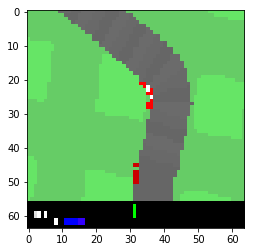

torch.Size([1, 64, 64, 3])


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


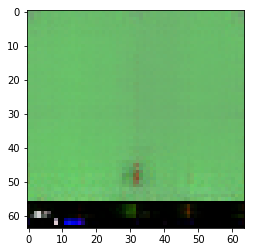

In [14]:
# Test
# Two problems:
# 1. Not learning very much over 10 epochs
# 2. Generate is not working at all
vrnn = VRNN().to(device)
vrnn.load_state_dict(torch.load('vrnn.pt', map_location='cpu'))

img = np.load('/floyd/input/car_racing_data/trial_1995_0.npz')['obs'][120]
img = Image.fromarray(img).resize((64,64))
plt.imshow(img)
plt.show()
hidden = torch.randn(1,256).to(device)
#vrnn.generate_images(1)
im = vrnn(ToTensor()(img).unsqueeze_(0).to(device),hidden)[0].detach()
print(im.permute(0,2,3,1).shape)
plt.imshow(im.permute((0,2,3,1))[0])
plt.show()

In [8]:
img = im.cpu().permute((0,2,3,1))
for _ in range(50):
    im_to_show = img.detach().numpy()[0]
    plt.imshow(im_to_show)

NameError: name 'im' is not defined

## LSTM-MDN

In [5]:
BATCH_SIZE = 1 # 100
MAX_SEQ_LEN = 199 # 999

LATENT_VEC = 50
HIDDEN_UNITS = 256
HIDDEN_DIM = 256
TEMPERATURE = 1.15
GAUSSIANS = 5
NUM_LAYERS = 1
PARAMS_CONTROLLER = HIDDEN_UNITS * NUM_LAYERS * 2 + LATENT_VEC
MDN_CONST = 1.0 / math.sqrt(2.0 * math.pi)
EPSILON = 1e-6

MAX_PLAYS = MAX_SEQ_LEN + 1
class LSTM(nn.Module):
    def __init__(self, sequence_len, batch_size, hidden_units, z_dim, num_layers, n_gaussians, hidden_dim):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        self.n_gaussians = n_gaussians
        self.num_layers = num_layers
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.hidden_units = hidden_units
        self.sequence_len = sequence_len
        self.hidden = self.init_hidden(self.sequence_len)

        self.fc1 = nn.Linear(self.z_dim + 3, self.hidden_dim)
        self.lstm = nn.LSTM(self.hidden_dim, hidden_units, num_layers)
        self.z_pi = nn.Linear(hidden_units, n_gaussians * self.z_dim)
        self.z_sigma = nn.Linear(hidden_units, n_gaussians * self.z_dim)
        self.z_mu = nn.Linear(hidden_units, n_gaussians * self.z_dim) 


    def forward(self, x):
        self.lstm.flatten_parameters()
        sequence = x.size()[1]

        # Hidden state
        x = F.relu(self.fc1(x))
        z, self.hidden = self.lstm(x, self.hidden)

        pi = self.z_pi(z).view(-1, sequence, self.n_gaussians, self.z_dim)
        pi = F.softmax(pi, dim=2)
        pi = pi / TEMPERATURE

        sigma = torch.exp(self.z_sigma(z)).view(-1, sequence,
                        self.n_gaussians, self.z_dim)
        sigma = sigma * (TEMPERATURE ** 0.5)
        mu = self.z_mu(z).view(-1, sequence, self.n_gaussians, self.z_dim)
    
        return pi, sigma, mu


    def init_hidden(self, sequence):
        hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_units, device=device)
        cell = torch.zeros(self.num_layers, self.batch_size, self.hidden_units, device=device)
        return hidden, cell

In [6]:
class LSTMDataset(Dataset):

    def __init__(self):
        """ Instanciate a dataset extending PyTorch """
        self.frames = []
        self.actions = []
        self.done = False
        
#         with open('/Users/zachrash/Desktop/driving_data/driving_log.csv') as f:
#             data = csv.reader(f, delimiter=',')
#             i = 0
#             frame = []
#             action = []
#             for j, (im, _, _, steering_angle, _, _, _) in enumerate(data):
#                 frame.append(np.array(Image.open(im).convert('RGB').resize((128,128))))
#                 action.append(float(steering_angle))
#                 i += 1
#                 if i == MAX_PLAYS:
#                     self.frames.append(frame)
#                     self.actions.append(action)
#                     frame = []
#                     action = []
#                     i = 0

        data_arr = []
        for i in os.listdir('/floyd/input/car_racing_data/'):
            data_arr.append(np.load(os.path.join('/floyd/input/car_racing_data/', i)))
        c = 0
        action = []
        frame = []
        for data in data_arr:
            for ob in data['obs']:
                frame.append(np.array(Image.fromarray(ob).resize((64,64))))
            for act in data['action']:
                action.append(np.array(act))
        
        self.frames = np.array_split(frame, len(frame) / MAX_PLAYS)
        self.actions = np.array_split(action, len(action) / MAX_PLAYS)
        temp = list(zip(self.frames, self.actions))
        np.random.shuffle(temp)
        frames, actions = zip(*temp)
        self.frames = np.array(frames)
        self.actions = np.array(actions)
                

    def __len__(self):
        return self.frames.shape[0]

    def __getitem__(self, idx):
        """Return zs, actions"""
        if self.frames[idx].shape[0] == 201:
            self.frames[idx] = self.frames[idx][:-1,:,:,:]
        if self.actions[idx].shape[0] == 201:
            self.actions[idx] = self.actions[idx][:-1,:]
        return np.rollaxis(self.frames[idx], 3, 1), \
               self.actions[idx]

In [60]:
# Test dataset
d = LSTMDataset()
dataloadertest = DataLoader(d, batch_size=1, num_workers=4, collate_fn=collate_fn)
for im, ac in dataloadertest:
    for i in im:
        #print c
        i = i.permute(1,2,0)
        plt.imshow(i)
        plt.show()
        continue

AxisError: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-10-3bdd56eef1bf>", line 55, in __getitem__
    return np.rollaxis(self.frames[idx], 3, 1),                self.actions[idx]
  File "/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py", line 1451, in rollaxis
    axis = normalize_axis_index(axis, n)
numpy.core._internal.AxisError: axis 3 is out of bounds for array of dimension 1


In [7]:
def mdn_loss_function(out_pi, out_sigma, out_mu, y):
    """
    Mixed Density Network loss function, see : 
    https://mikedusenberry.com/mixture-density-networks
    """
    result = Normal(loc=out_mu, scale=out_sigma)
    y = y.view(MAX_SEQ_LEN+1, BATCH_SIZE, LATENT_VEC+3)
    result = torch.exp(result.log_prob(y))
    result = torch.sum(result * out_pi, dim=2)
    result = -torch.log(EPSILON + result)
    return torch.mean(result)


def sample_z(pi, sigma, mu):
    return torch.sum(pi*(mu+sigma), dim=2)


def collate_fn(example):
    """ Custom way of flattening examples in a batch """
    frames = []
    actions = []
    for ex in example:
        frames.extend(ex[0])
        actions.extend(ex[1])
    frames = torch.tensor(frames, dtype=torch.float) / 255.0
    actions = torch.tensor(actions, dtype=torch.float)
    return frames, actions


def train_lstm():
    # Init VAE
    vae = VAE((320, 160, 3), 50).to(device)
    vae.load_state_dict(torch.load('model.pt', map_location='cpu'))
    
    # Init LSTM
    lstm = LSTM(MAX_SEQ_LEN, BATCH_SIZE, HIDDEN_UNITS, LATENT_VEC, NUM_LAYERS, GAUSSIANS, HIDDEN_DIM).to(device)
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-4)

    dataset = LSTMDataset()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, collate_fn=collate_fn)
    epochs = 100
    
    for e in range(epochs):
        print("Epoch: {}/{}".format(e+1, epochs))
        for batch_idx, (frames, actions) in enumerate(dataloader):
            frames = frames.squeeze_(0).to(device)
            actions = actions.squeeze_(0).to(device)
            encoded = vae(frames, encode=True)
            example = {
                'encoded': encoded,
                'actions' : actions
            }

            optimizer.zero_grad()
            lstm.hidden = lstm.init_hidden(MAX_SEQ_LEN+3) # ??
#             x = torch.cat((example['encoded'],
#                            example['actions'].view(-1, 3)), dim=1)
#             x = x.view(MAX_SEQ_LEN+1, BATCH_SIZE, LATENT_VEC + 3)
#             print(x.shape)

#             ## Shift target encoded vector
#             last_ex = example['encoded'][-1].view(-1, example['encoded'].size()[1])
#             print(last_ex.shape)
#             target = torch.cat((example['encoded'][1:example['encoded'].size()[0]],\
#                                   last_ex,), dim=1)
#             print (target.shape)
            
            x = torch.cat((example['encoded'],
                    example['actions']), dim=1)
            #print(x.shape)
            x = x.view(MAX_SEQ_LEN+1, 1, LATENT_VEC + 3)
            #print(x_raw.shape)
            # x = x_raw[:-1,:,:]
            print(x.shape)
            # print(example['encoded'][1:,:].unsqueeze_(0).shape)
            target = example['encoded'][1:,:].unsqueeze_(0).view(MAX_SEQ_LEN, BATCH_SIZE, LATENT_VEC)
            # print (target.shape)
            
            last_ex = example['encoded'][-1].view(-1, example['encoded'].size()[1])
            target = torch.cat((example['encoded'][1:example['encoded'].size()[0]],last_ex,))
            pi, sigma, mu = lstm(x)
            loss = mdn_loss_function(pi, sigma, mu, target)
            loss.backward()
            optimizer.step()
            if batch_idx %20 == 0:
                print('Loss: {}'.format(float(loss.data)))
            
    torch.save(lstm.state_dict(), 'lstm.pt')

In [70]:
train_lstm()

Epoch: 1/100
torch.Size([200, 1, 53])


RuntimeError: invalid argument 2: size '[200 x 1 x 53]' is invalid for input with 10000 elements at /pytorch/aten/src/TH/THStorage.cpp:84

In [13]:
lstm = LSTM(1, BATCH_SIZE, HIDDEN_UNITS, LATENT_VEC, NUM_LAYERS, GAUSSIANS, HIDDEN_DIM).to(device)
lstm.load_state_dict(torch.load('lstm.pt', map_location='cpu'))

In [14]:
# Test VAE + LSTM
data_dir = '/Users/zachrash/Desktop/driving_data/driving_log.csv'
r = random.randint(0, 800)
with open(data_dir, 'r') as f:
    data = csv.reader(f, delimiter=',')
    angles = []
    for i, (images,_,_,a,_,_,_) in enumerate(data):
        angles.append(float(a))
        if i == r:
            f_image = images
            f_a = a
        if i == r+30:
            s_image = images
            s_a = a

im = vae(ToTensor()(Image.open(f_image).convert('RGB').resize((64,128))).unsqueeze_(0))[0]
z = vae(ToTensor()(Image.open(f_image).convert('RGB').resize((128,128))).unsqueeze_(0), encode=True)
next_z = z
# for i in range(30):
#     next_z = next_z[0]
#     inp = torch.cat((z.unsqueeze_(0), torch.tensor([[angles[i]]])), dim=1).unsqueeze_(0)
#     pi, sigma, mu = lstm(inp)
#     _, z_next = torch.max(pi[0,0,:,:], 0)

z = z[0].float()
inp = torch.cat((z.unsqueeze_(0), torch.tensor([[angles[i]]])), dim=1).unsqueeze_(0)
pi, sigma, mu = lstm(inp)

z = sample_z(pi, sigma, mu)[0,0,:,:]

im = vae.decode(z.float())
im = ToPILImage()(im[0,:,:,:])
plt.imshow(im)
plt.show()
# print pi[0].shape
# print np.max(pi[0,0,:,:].detach().numpy())
# for p in pi[0,0,:,:]:
#     zs.append(p)

# for z in zs:
#     im = vae.decode(z.float())
#     im = ToPILImage()(im[0,:,:,:])
#     plt.imshow(im)
#     plt.show()
# _, z_next = torch.max(pi[0,0,:,:], 0)

# next_im = vae.decode(z_next.float())
# next_im = ToPILImage()(next_im[0,:,:,:])    
# im = ToPILImage()(im[0,:,:,:])
# plt.imshow(Image.open(f_image))
# plt.show()
# plt.imshow(im)
# plt.show()
# plt.imshow(Image.open(s_image))
# plt.show()
# plt.imshow(next_im)
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zachrash/Desktop/driving_data/driving_log.csv'

In [14]:
# Test Generative M
z_next = Normal(0, 1).sample((1,50))

for i in range(1000):
    x = torch.cat((z_next,
                  torch.Tensor([0.0]).unsqueeze_(0),
                  torch.Tensor([1.0]).unsqueeze_(0),
                  torch.Tensor([0.0]).unsqueeze_(0)), dim=1)
    z_next = lstm(x.unsqueeze_(0).to(device))
    z_next = sample_z(*z_next)
    next_im = vae.decode(z_next.to(device))
    z_next = z_next.squeeze_(0)
    if i %100 == 0:
        plt.imshow(ToPILImage()(next_im[0,:,:,:]))
        plt.show()

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.